<a href="https://colab.research.google.com/github/bmounikareddy98/Machine-learning-project/blob/main/rnn_using_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Team members:**

1. Saketh Dasavathini(SXD190016)
2. Mounika B(MXB210007)
3. Harshavardhan Naregudam(HRN210000)
4. Nikhila Remala(NXR190032) 

**Importing the required libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


**Error function**

In [ ]:
def error_function(real_Value,predicted_Value):
    #squared error
    sse=((real_Value- predicted_Value)**2)
    #mean squared error
    mean_squared_error= np.mean(sse)
    #root mean squared error
    root_mean_squared_error=np.sqrt(mean_squared_error)
    
    return mean_squared_error,root_mean_squared_error



**Plot function for graphs**

In [ ]:
# plotting of graphs
def plot_graphs(real_value, training_data, test_data):
    plt.plot(real_value, label="The actual value", color="red")
    plt.plot(training_data, label="Prediction on training data", color='blue')
    test_data = [j for j in test_data]
    # connecting training and testing lines
    test_data.insert(0, training_data[-1])
    # X values for testing prediction plot
    plt.plot([x for x in range(len(training_data) - 1, len(training_data) + len(test_data) - 1)], test_data, label="Prediction on testing data", color='green')
    plt.xlabel("Time period in Days")
    plt.ylabel("Stock Price")
    plt.title("Stock $ Prediction")
    plt.legend()
    plt.grid()
    plt.show()

**Long Short Term Memory class containing all functions for forget gate, input gate,output gate, forward propagation and back propagation**

In [ ]:
class LongShortTermMemory:

    def __init__(self, input_nodes=2, cell_weights=2, output_nodes=1, learning_rate=0.5):
        # Setting the number of nodes in each input, hidden and output layers
        self.InputNodes = input_nodes
        self.CellWeights = cell_weights
        self.OutputNodes = output_nodes

        # fgw = Forget gate's weights
        self.fgw =np.random.randn(self.InputNodes, self.CellWeights).T
        

        # igw = Input gate's weights
        self.igw = np.random.randn(self.InputNodes, self.CellWeights).T

        # ogw = Output gate's weights
        self.ogw = np.random.randn(self.InputNodes, self.CellWeights).T

        # cgw = Candidate gate's weights
        self.cgw = np.random.randn(self.InputNodes, self.CellWeights).T
        
        # l = weights from LSTM cells to output
        self.l = np.random.randn(2, 1).T

        # Default LSTM cell states are declared below
        self.CellState = [[1, 1] for j in range(100)]
        self.CellState = np.array(self.CellState, dtype=float)
        self.CellState = np.array(self.CellState, ndmin=2).T
        self.learning_rate = learning_rate # setting a learning rate

    # Defining the sigmoid activation function to be used at forget gates
    def sigmoid_activation_function(self, x):
        sigmoid= 1/(1+np.exp(-x))
        return sigmoid

    # Defining the tanh activation function to be used at input gates
    def tanh_activation_function(self, x):
        tanh= 1 - np.square(np.tanh(x))
        return tanh

    def ForgetGate(self, input_from_gate, output=1):
        input_from_gate = np.dot(self.fgw, input_from_gate)
        input_from_gate = output * input_from_gate
        output_to_gate = self.sigmoid_activation_function(input_from_gate)
        self.CellState = self.CellState * output_to_gate

    def InputGate(self, input_from_gate, output=1):
        input_from_gate_1 = (np.dot(self.igw, input_from_gate))*output
        #input_from_gate_2 = (np.dot(self.igw, input_from_gate))*output
        #input_from_gate_1 = (np.dot(self.igw, input_from_gate))*output
        input_from_gate_2 = np.dot(self.cgw, input_from_gate)*output
        #gate_input_2 = out * gate_input_2
        output_to_gate = self.sigmoid_activation_function(input_from_gate_1) * self.tanh_activation_function(input_from_gate_2)
        self.CellState = self.CellState + output_to_gate

    def OutputGate(self, input_from_gate, output=1):
        input_from_gate = np.dot(self.ogw, input_from_gate)
        input_from_gate = output * input_from_gate
        output_to_gate = self.sigmoid_activation_function(input_from_gate)
        output = self.tanh_activation_function(self.CellState) * output_to_gate

        return output

    def forward_propagation(self, inp_1, inp_2, inp_3):
        self.CellState = [[1, 1] for j in range(len(inp_1[0]))]
        self.CellState = np.array(self.CellState, dtype=float)
        self.CellState = np.array(self.CellState, ndmin=2).T
        # Input is passed through first cell in lstm network
        self.ForgetGate(inp_1)
        self.InputGate(inp_1)
        output = self.OutputGate(inp_1)
        # Input is passed through second cell in lstm network
        self.ForgetGate(inp_2, output)
        self.InputGate(inp_2, output)
        output = self.OutputGate(inp_2, output)
        # Input is passed through third cell in lstm network
        self.ForgetGate(inp_3, output)
        self.InputGate(inp_3, output)
        output = self.OutputGate(inp_3, output)
        #Dot product of output weights and final cell's output
        f_input = np.dot(self.l, output)
        #output of the neural network
        f_output = self.sigmoid_activation_function(f_input) 
        return f_output, output

    def errors(self, targeted_output, f_output):
        #print(targeted_output.shape)
        #print(f_output.shape)
        error_in_output = targeted_output - f_output
        error_in_hiddenlayer = np.dot(self.l.T, error_in_output)

        return error_in_output, error_in_hiddenlayer

    def Back_propagation(self, training_1, training_2, training_3, f_out, f_output, error_in_output,
                        error_in_cell):
        self.l =self.l+ (self.learning_rate * np.dot((error_in_output * (1.0 - f_output)), f_out.T))
        self.fgw = self.fgw+ (self.learning_rate * np.dot((error_in_cell * f_out * (1.0 - f_out)), training_1.T))
        self.igw = self.igw+ (self.learning_rate * np.dot((error_in_cell * f_out * (1.0 - f_out)), training_2.T))
        self.cgw = self.cgw+ (self.learning_rate * np.dot((error_in_cell * f_out * (1.0 - f_out)), training_2.T))
        self.ogw = self.ogw+ (self.learning_rate * np.dot((error_in_cell * f_out * (1.0 - f_out)), training_3.T))

    def training(self, training_1, training_2, training_3, targeted_variable):
        # convert lists to 2d arrays
        training_1 = np.array(training_1, ndmin=2).T
        training_2 = np.array(training_2, ndmin=2).T
        training_3 = np.array(training_3, ndmin=2).T
        targeted_variable = np.array(targeted_variable, ndmin=2).T

        # calling the forward propagation
        f_output, f_out = self.forward_propagation(training_1, training_2, training_3)

        # Calcualting the errors in output and cell
        error_in_output, error_in_cell = self.errors(targeted_variable, f_output)

        # Calling the back propagation after calculating the errors
        self.Back_propagation(training_1, training_2, training_3, f_out, f_output, error_in_output,
                             error_in_cell)

        return f_output

    def testing(self, testing_1, testing_2, testing_3):
        # transpose input
        testing_1 = testing_1.T
        testing_2 = testing_2.T
        testing_3 = testing_3.T
        # Calling forward propagation for testing
        f_output, f_out = self.forward_propagation(testing_1, testing_2, testing_3)
        # return final input
        return f_output

**Main function consisting all the LSTM function calls for training data and test data**

Training cycle: 0
Training cycle: 1
Training cycle: 2
Training cycle: 3
Training cycle: 4
Training cycle: 5
Training cycle: 6
Training cycle: 7
Training cycle: 8
Training cycle: 9
Training cycle: 10
Training cycle: 11
Training cycle: 12
Training cycle: 13
Training cycle: 14
Training cycle: 15
Training cycle: 16
Training cycle: 17
Training cycle: 18
Training cycle: 19
Training cycle: 20
Training cycle: 21
Training cycle: 22
Training cycle: 23
Training cycle: 24
Training cycle: 25
Training cycle: 26
Training cycle: 27
Training cycle: 28
Training cycle: 29
Training cycle: 30
Training cycle: 31
Training cycle: 32
Training cycle: 33
Training cycle: 34
Training cycle: 35
Training cycle: 36
Training cycle: 37
Training cycle: 38
Training cycle: 39
Training cycle: 40
Training cycle: 41
Training cycle: 42
Training cycle: 43
Training cycle: 44
Training cycle: 45
Training cycle: 46
Training cycle: 47
Training cycle: 48
Training cycle: 49
Training cycle: 50
Training cycle: 51
Training cycle: 52
Tra

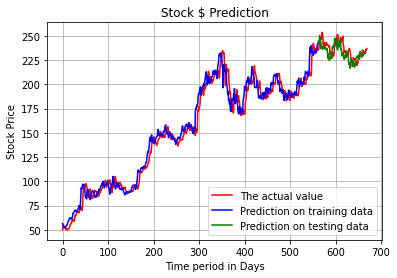

In [ ]:
def main():
    # read into dataframe
    url="https://raw.githubusercontent.com/bmounikareddy98/Machine-learning-project/main/GOOG%20(4).csv"
    data = pd.read_csv(url)
    data = data['Adj Close']
    #normalization value
    n_value=1000
    #1st two days
    training_1 = [[data[j-6], data[j-5]] for j in range(len(data[:570])) if j >= 6]
    #3rd and 4th day
    training_2 = [[data[j-4], data[j-3]] for j in range(len(data[:570])) if j >= 6]
    #5th and 6th day
    training_3 = [[data[j-2], data[j-1]] for j in range(len(data[:570])) if j >= 6]
    #7th day or targeted train_pred
    training_y = [[j] for j in data[6:570]]
    
    #convert into arrays
    training_1 = np.array(training_1, dtype=float)
    training_2 = np.array(training_2, dtype=float)
    training_3 = np.array(training_3, dtype=float)
    training_y = np.array(training_y, dtype=float)
   
    # Normalize
    training_1= training_1/n_value
    training_2 = training_2/n_value
    training_3 = training_3/n_value
    training_y = training_y/n_value

    # create neural networks
    LSTM = LongShortTermMemory()

    # number of training cycles
    train_cycles = 100
    # training the LSTM network
    for c in range(train_cycles):
        print("Training cycle: "+str(c))
        for n in training_1:
            training_prediction = LSTM.training(training_1, training_2, training_3, training_y)

    # Determinning errors
    
    error_mse_train, error_rmse_train=error_function(training_y,training_prediction)
    print("Mean squared error of train data: "+ str(error_mse_train))
    print("Root mean squared error of train data: "+ str(error_rmse_train))
    # de-Normalize
    training_prediction = np.array(training_prediction, dtype=float)
    training_prediction *=n_value
    training_y *=n_value*10
    
    # transpose
    training_prediction = training_prediction.T




    testing_1 = [[data[j - 6], data[j - 5]] for j in range(570, 670)]
    testing_2 = [[data[j - 4], data[j - 3]] for j in range(570, 670)]
    testing_3 = [[data[j - 2], data[j - 1]] for j in range(570, 670)]
    testing_y = [[j] for j in data[570:670]]

    testing_1 = np.array(testing_1, dtype=float)
    testing_2 = np.array(testing_2, dtype=float)
    testing_3 = np.array(testing_3, dtype=float)
    testing_y = np.array(testing_y, dtype=float)


    # Normalization

    testing_1 = testing_1/n_value
    testing_2 = testing_2/n_value
    testing_3 = testing_3/n_value
    testing_y = testing_y/n_value

    # test_pred the network with unseen data
    testing_prediction = LSTM.testing(testing_1, testing_2, testing_3)
    testing_prediction = np.array(testing_prediction, dtype=float)

    # print various accuracies
    error_mse_test, error_rmse_test=error_function(testing_y, testing_prediction)
    print("Mean squared error of test data: "+ str(error_mse_test))
    print("Root mean squared error of test data: "+ str(error_rmse_test))

    # de-Normalize data
    testing_prediction = testing_prediction * n_value

    testing_y = testing_y * n_value*10


    # transplose test_pred results
    testing_prediction = testing_prediction.T



    # plotting training and test_pred results on same graph
    
    #print(df.head())
    data = data.to_frame()
    #print(df['Adj Close'].values)
    
    plot_graphs(data['Adj Close'].values[0:670], training_prediction, testing_prediction)


if __name__ == '__main__':
    main()